## Tutorial soures
https://www.kaggle.com/ternaryrealm/lstm-time-series-explorations-with-keras
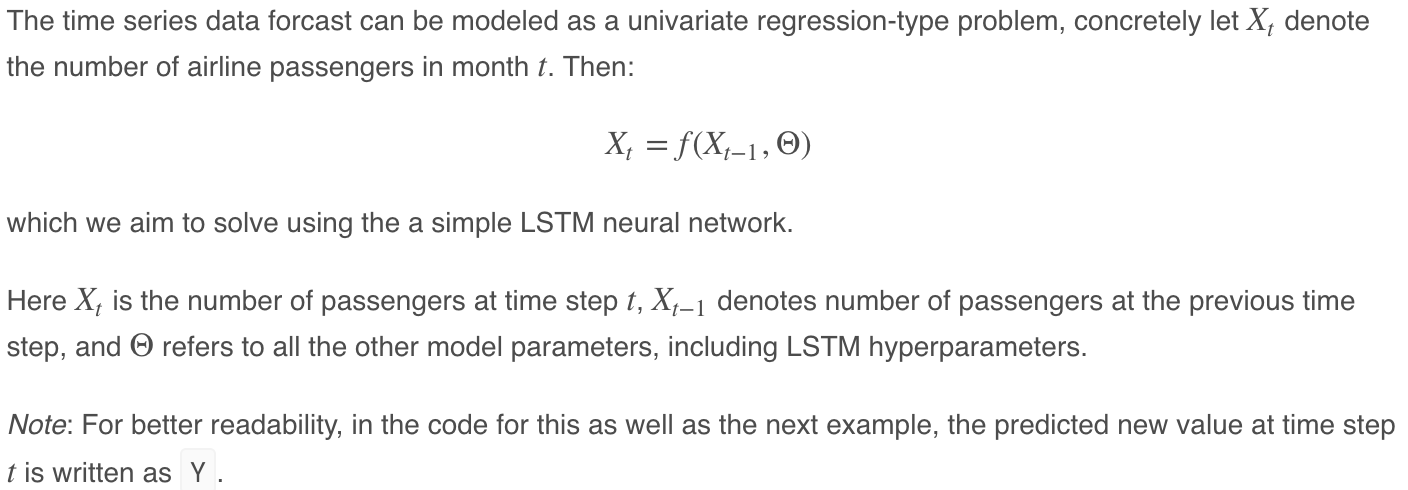
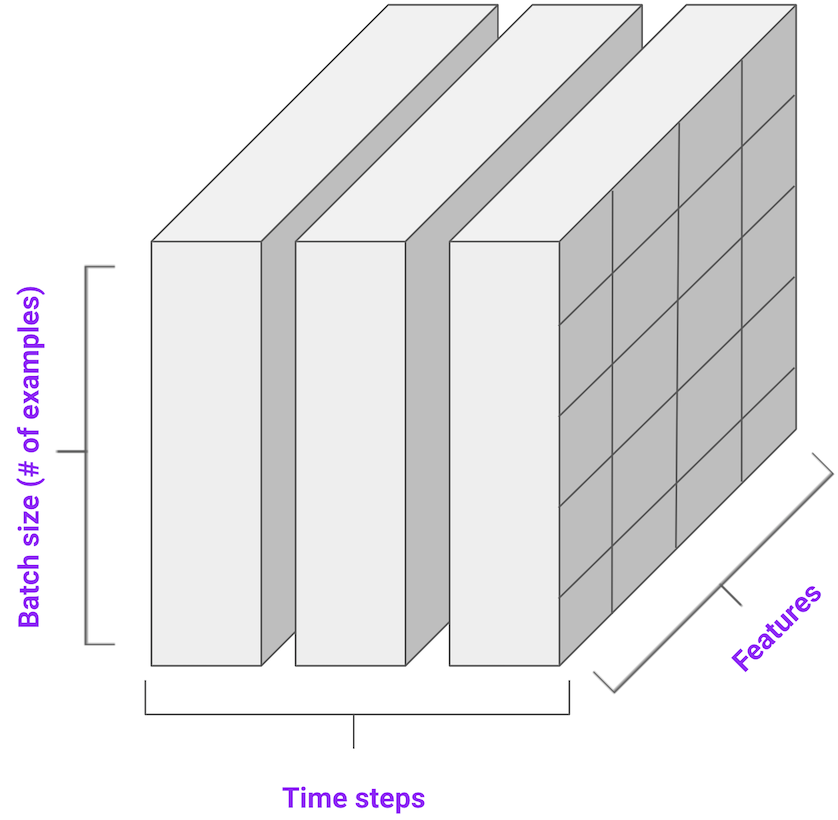
The input of the LSTM is always is a 3D array. (batch_size, time_steps, input_dim)

## Libs

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib as matpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import math
import seaborn as sns


# Using the Tensorflow backend (default).
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


matpl.rcParams['figure.figsize'] = (20, 15)
plt.style.use('seaborn-darkgrid')
%matplotlib inline

Using TensorFlow backend.


## Data

In [2]:
%store -r data_GLD
data_GLD.head(2)

,Adj Close
Date,
2009-06-01,93.709999
2009-06-08,92.169998


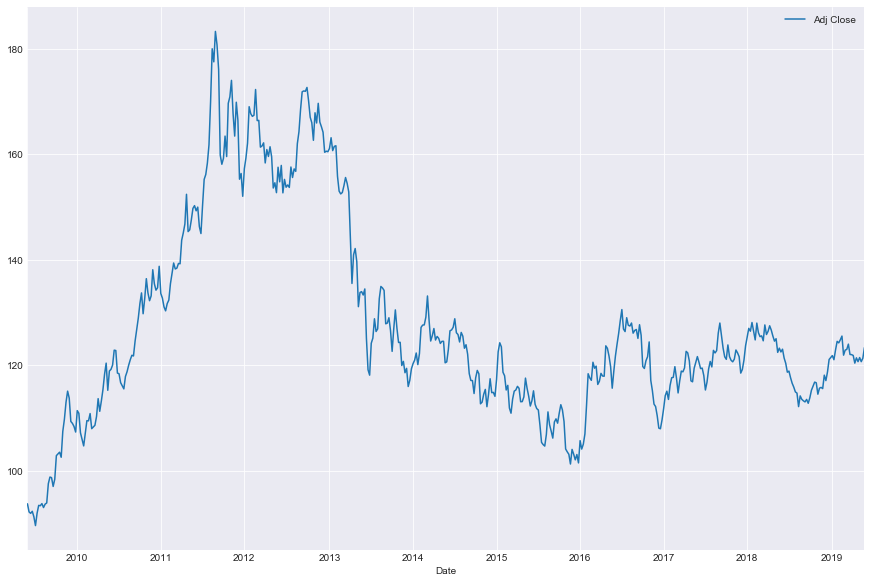

In [3]:
data_GLD.plot(figsize=(15,10))

In [4]:
mm = MinMaxScaler(feature_range = (0,1))

In [5]:
#scale data between 0 1 to enhance numerical stability
dataset = mm.fit_transform(data_GLD)

In [6]:
#visualize a dataset[0:2]few data
dataset[0:2]

array([[0.04409563],
       [0.02765317]])

1 data every week. 52 data per year, 522 data in total.
* use the past 2 months (8 weeks) to predict 1 week ahead.
* create window of last 8 obs to train model
Parameters:
* history_size - size of past window
* target_size - how far in future model should learn to predict

6 years of training data = 313 weeks. 
Rest of the 209 weeks are for validation.

In [7]:
split_size = 0.6

train_size = int(len(dataset) * split_size)
test_size = len(dataset) - train_size

train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (313, 209)


In [16]:
lookback = 4

In [30]:
def create_dataset(dataset, lookback, window_size):
    data_X, data_Y = [], []
    for i in range(len(dataset) - lookback - window_size -1):
        a = dataset[i:(i + lookback + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i+lookback + window_size, 0])
    return(np.array(data_X), np.array(data_Y))


In [31]:
# Create test and train sets for one-step-ahead regression.
window_size = 1

train_X, train_Y = create_dataset(train, lookback, window_size)
test_X, test_Y = create_dataset(test,lookback, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
# 
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(307, 5)
New training data shape:
(307, 1, 5)


In [32]:
train_X.shape[0]

307

## Univar Forecasting Model

According to Keras documentation, validation is done as such:
* "validation_split: Float between 0 and 1. Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. The validation data is selected from the last samples in the x and y data provided, before shuffling."

LSTM model
* One input later
* 2 LSTM hidden layers: first with 64 blocks, second with 32 blocks
* Dense layer to give single output
* MSE as loss function

In [35]:
NUM_NEURONS_FirstLayer = 64
NUM_NEURONS_SecondLayer = 32
EPOCHS = 200

#Build the model
def fit_model(train_X, train_Y, lookback, window_size):
    history = []
    model = Sequential()
    model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(lookback, window_size), return_sequences=True))
    model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')

    model.fit(train_X,train_Y,validation_split = 0.1,epochs=EPOCHS,shuffle=True,batch_size=25, verbose=2)
    return(model)

model1 = fit_model(train_X, train_Y, window_size, lookback+1)

Train on 276 samples, validate on 31 samples
Epoch 1/200
 - 5s - loss: 0.2577 - val_loss: 0.0444
Epoch 2/200
 - 0s - loss: 0.1644 - val_loss: 0.0156
Epoch 3/200
 - 0s - loss: 0.0729 - val_loss: 0.0011
Epoch 4/200
 - 0s - loss: 0.0138 - val_loss: 0.0113
Epoch 5/200
 - 0s - loss: 0.0097 - val_loss: 0.0111
Epoch 6/200
 - 0s - loss: 0.0076 - val_loss: 0.0059
Epoch 7/200
 - 0s - loss: 0.0070 - val_loss: 0.0054
Epoch 8/200
 - 0s - loss: 0.0069 - val_loss: 0.0062
Epoch 9/200
 - 0s - loss: 0.0062 - val_loss: 0.0043
Epoch 10/200
 - 0s - loss: 0.0056 - val_loss: 0.0043
Epoch 11/200
 - 0s - loss: 0.0056 - val_loss: 0.0036
Epoch 12/200
 - 0s - loss: 0.0052 - val_loss: 0.0031
Epoch 13/200
 - 0s - loss: 0.0051 - val_loss: 0.0029
Epoch 14/200
 - 0s - loss: 0.0049 - val_loss: 0.0023
Epoch 15/200
 - 0s - loss: 0.0056 - val_loss: 0.0024
Epoch 16/200
 - 0s - loss: 0.0046 - val_loss: 0.0021
Epoch 17/200
 - 0s - loss: 0.0047 - val_loss: 0.0020
Epoch 18/200
 - 0s - loss: 0.0043 - val_loss: 0.0021
Epoch 19/2

 - 0s - loss: 0.0027 - val_loss: 7.8984e-04
Epoch 150/200
 - 0s - loss: 0.0025 - val_loss: 0.0011
Epoch 151/200
 - 0s - loss: 0.0023 - val_loss: 8.3399e-04
Epoch 152/200
 - 0s - loss: 0.0027 - val_loss: 9.3366e-04
Epoch 153/200
 - 0s - loss: 0.0024 - val_loss: 9.5682e-04
Epoch 154/200
 - 0s - loss: 0.0019 - val_loss: 9.3429e-04
Epoch 155/200
 - 0s - loss: 0.0024 - val_loss: 8.7839e-04
Epoch 156/200
 - 0s - loss: 0.0026 - val_loss: 0.0011
Epoch 157/200
 - 0s - loss: 0.0021 - val_loss: 9.8135e-04
Epoch 158/200
 - 0s - loss: 0.0025 - val_loss: 7.6762e-04
Epoch 159/200
 - 0s - loss: 0.0023 - val_loss: 9.1221e-04
Epoch 160/200
 - 0s - loss: 0.0022 - val_loss: 7.7990e-04
Epoch 161/200
 - 0s - loss: 0.0023 - val_loss: 7.9411e-04
Epoch 162/200
 - 0s - loss: 0.0020 - val_loss: 7.9559e-04
Epoch 163/200
 - 0s - loss: 0.0023 - val_loss: 7.7079e-04
Epoch 164/200
 - 0s - loss: 0.0026 - val_loss: 0.0011
Epoch 165/200
 - 0s - loss: 0.0021 - val_loss: 8.0289e-04
Epoch 166/200
 - 0s - loss: 0.0021 - val

## Results 
### Predictions and model evaluations
The advantage of using the RMSE is that it's in the same unit as the original data, i.e. price/wk (1.000 passengers / month in Kaggle example).

In [36]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = mm.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = mm.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 3.34 RMSE
Test data score: 2.38 RMSE


### Plotting and comparing original data, predictions, forecasts

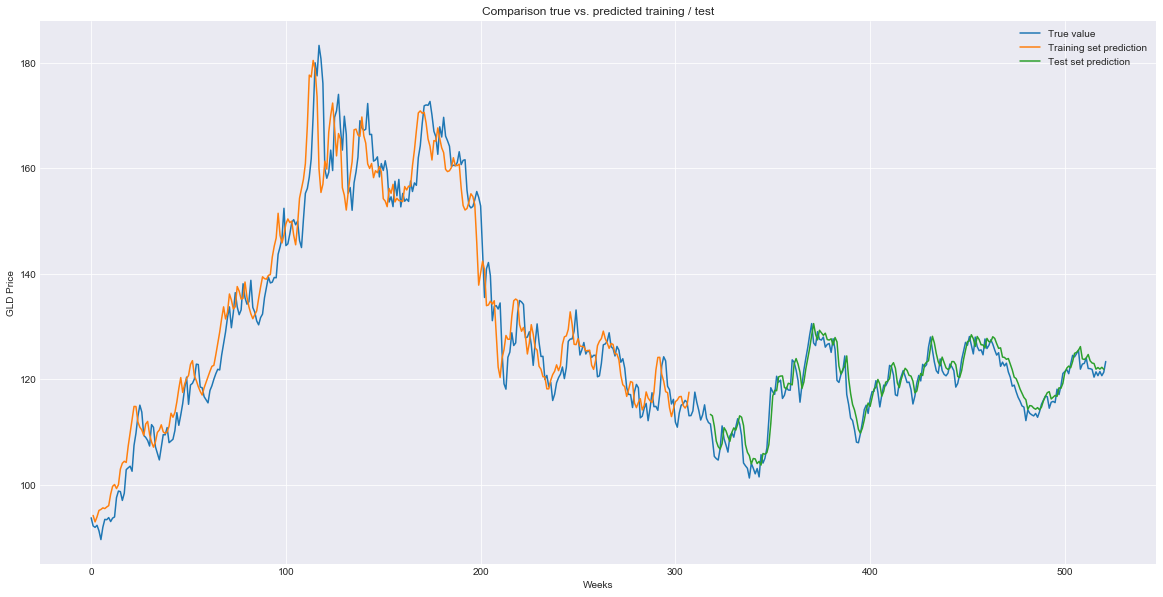

In [38]:
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + ((window_size+lookback) * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (20, 10))
plt.plot(mm.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Weeks")
plt.ylabel("GLD Price")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()